<a href="https://colab.research.google.com/github/lahirunie-dulsara/EN3150-Assignment-3-CNN/blob/Sakith/RealWaste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive


In [2]:
import zipfile, os, re, shutil
from PIL import Image

zip_path = "/content/drive/MyDrive/Real Waste.zip"

extract_path = "/content/extracted_zip"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Unzipped to:", extract_path)


Unzipped to: /content/extracted_zip


In [3]:
base_dir = "/content/extracted_zip/realwaste-main/RealWaste"
for folder in os.listdir(base_dir):
    count = len(os.listdir(os.path.join(base_dir, folder)))
    print(f"{folder}: {count} images")

Vegetation: 436 images
Plastic: 921 images
Metal: 790 images
Paper: 500 images
Cardboard: 461 images
Textile Trash: 318 images
Miscellaneous Trash: 495 images
Glass: 420 images
Food Organics: 411 images


In [4]:
pip install split-folders

In [5]:
import splitfolders

input_folder = "/content/extracted_zip/realwaste-main/RealWaste"
output_folder = "/content/extracted_zip/realwaste-main/realwaste_split"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .15, .15))

Copying files: 4752 files [00:03, 1433.46 files/s]


In [6]:
base_dir = "/content/extracted_zip/realwaste-main/realwaste_split"

for split in ['train', 'val', 'test']:
    split_path = os.path.join(base_dir, split)
    print(f"\n{split.upper()} SET")
    total = 0
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        count = len(os.listdir(cls_path))

        total += count
        print(f"  {cls}: {count} images")
    print(f"Total {split}: {total} images")


TRAIN SET
  Vegetation: 305 images
  Plastic: 644 images
  Metal: 553 images
  Paper: 350 images
  Cardboard: 322 images
  Textile Trash: 222 images
  Miscellaneous Trash: 346 images
  Glass: 294 images
  Food Organics: 287 images
Total train: 3323 images

VAL SET
  Vegetation: 65 images
  Plastic: 138 images
  Metal: 118 images
  Paper: 75 images
  Cardboard: 69 images
  Textile Trash: 47 images
  Miscellaneous Trash: 74 images
  Glass: 63 images
  Food Organics: 61 images
Total val: 710 images

TEST SET
  Vegetation: 66 images
  Plastic: 139 images
  Metal: 119 images
  Paper: 75 images
  Cardboard: 70 images
  Textile Trash: 49 images
  Miscellaneous Trash: 75 images
  Glass: 63 images
  Food Organics: 63 images
Total test: 719 images


In [7]:
import os
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(20),
    # transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

train_dataset = datasets.ImageFolder("/content/extracted_zip/realwaste-main/realwaste_split/train", transform=train_transforms)
val_dataset   = datasets.ImageFolder("/content/extracted_zip/realwaste-main/realwaste_split/val", transform=val_test_transforms)
test_dataset  = datasets.ImageFolder("/content/extracted_zip/realwaste-main/realwaste_split/test", transform=val_test_transforms)

# Get number of classes and device early
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Number of classes: {num_classes}")

Using device: cuda
Number of classes: 9


In [8]:
class_counts = np.bincount(train_dataset.targets)
print("Class counts:", class_counts)

class_weights_tensor = 1. / torch.tensor(class_counts, dtype=torch.float)

sample_weights = [class_weights_tensor[label].item() for label in train_dataset.targets]

print("\nClass counts per category:")
for cls, count in zip(train_dataset.classes, class_counts):
    print(f"  {cls:15s}: {count}")

print("\nClass weights (inverse of frequency):")
for cls, w in zip(train_dataset.classes, class_weights_tensor):
    print(f"  {cls:15s}: {w:.6f}")

Class counts: [322 287 294 553 346 350 644 222 305]

Class counts per category:
  Cardboard      : 322
  Food Organics  : 287
  Glass          : 294
  Metal          : 553
  Miscellaneous Trash: 346
  Paper          : 350
  Plastic        : 644
  Textile Trash  : 222
  Vegetation     : 305

Class weights (inverse of frequency):
  Cardboard      : 0.003106
  Food Organics  : 0.003484
  Glass          : 0.003401
  Metal          : 0.001808
  Miscellaneous Trash: 0.002890
  Paper          : 0.002857
  Plastic        : 0.001553
  Textile Trash  : 0.004505
  Vegetation     : 0.003279


In [9]:
BATCH_SIZE = 64

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


print(f"\nWeightedRandomSampler created successfully!")
print(f"Total samples in epoch: {len(sample_weights)}")
print(f"Training Batch size: {train_loader.batch_size}")
print(f"Validation Batch size: {val_loader.batch_size}")
print(f"Total training batches per epoch: {len(train_loader)}")


WeightedRandomSampler created successfully!
Total samples in epoch: 3323
Training Batch size: 64
Validation Batch size: 64
Total training batches per epoch: 52


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import copy

class WasteCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(WasteCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self._to_linear = None
        self.calculate_flatten_size(256)

        self.fc1 = nn.Linear(self._to_linear, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def calculate_flatten_size(self, input_size):
        with torch.no_grad():
            x = torch.zeros(1, 3, input_size, input_size)
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, self._to_linear)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

print("WasteCNN model class defined and ready for use.")

WasteCNN model class defined and ready for use.


In [11]:

def get_fresh_model_for_comparison(num_classes, device, base_model_path='initial_model_weights.pth'):
    if not os.path.exists(base_model_path):
        initial_model = WasteCNN(num_classes=num_classes).to(device)
        torch.save(initial_model.state_dict(), base_model_path)
        print(f"Created and saved initial model weights to {base_model_path}")
        return initial_model
    else:
        new_model = WasteCNN(num_classes=num_classes).to(device)
        new_model.load_state_dict(torch.load(base_model_path))
        return new_model

def run_optimizer_training_comparison(model_instance, optimizer_name, optimizer_obj, criterion_obj, scheduler_obj, num_epochs_comp, train_loader_comp, val_loader_comp, device_comp):
    print(f"\nTraining with {optimizer_name} for {num_epochs_comp} epochs...")

    current_train_losses = []
    current_train_accuracies = []
    current_val_losses = []
    current_val_accuracies = []

    best_val_acc_run = 0.0
    model_path_run = f'best_model_comparison_{optimizer_name.lower().replace(" ", "_").replace("-", "_")}.pth'

    for epoch in range(num_epochs_comp):
        model_instance.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        train_loop = tqdm(train_loader_comp, desc=f"Epoch {epoch+1}/{num_epochs_comp} ({optimizer_name} Train)", leave=False)
        for images, labels in train_loop:
            images, labels = images.to(device_comp), labels.to(device_comp)

            optimizer_obj.zero_grad()
            outputs = model_instance(images)
            loss = criterion_obj(outputs, labels)
            loss.backward()
            optimizer_obj.step()

            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            train_loop.set_postfix(loss=loss.item())

        epoch_train_loss = running_loss / len(train_loader_comp.dataset)
        epoch_train_accuracy = 100 * train_correct / train_total
        current_train_losses.append(epoch_train_loss)
        current_train_accuracies.append(epoch_train_accuracy)

        if scheduler_obj:
            scheduler_obj.step()

        model_instance.eval()
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0

        with torch.no_grad():
            val_loop = tqdm(val_loader_comp, desc=f"Epoch {epoch+1}/{num_epochs_comp} ({optimizer_name} Val)", leave=False)
            for images, labels in val_loop:
                images, labels = images.to(device_comp), labels.to(device_comp)
                outputs = model_instance(images)
                loss = criterion_obj(outputs, labels)
                val_running_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader_comp.dataset)
        epoch_val_accuracy = 100 * val_correct / val_total
        current_val_losses.append(epoch_val_loss)
        current_val_accuracies.append(epoch_val_accuracy)

        print(f"  {optimizer_name} - Epoch [{epoch+1}/{num_epochs_comp}] "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_accuracy:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Accuracy: {epoch_val_accuracy:.2f}%")

        if epoch_val_accuracy > best_val_acc_run:
            best_val_acc_run = epoch_val_accuracy
            torch.save(model_instance.state_dict(), model_path_run)

    print(f"--- {optimizer_name} training finished. Best Val Accuracy: {best_val_acc_run:.2f}% ---")
    return current_train_losses, current_train_accuracies, current_val_losses, current_val_accuracies, model_path_run

In [12]:
print("\n" + "="*75)
print("       Starting Optimizer Performance Comparison Training       ")
print("="*75 + "\n")

_ = get_fresh_model_for_comparison(num_classes, device)

NUM_EPOCHS_COMP = 20
criterion_comp = nn.CrossEntropyLoss()

# 1. Adam Optimizer Configuration
model_adam_comp = get_fresh_model_for_comparison(num_classes, device)
optimizer_adam_comp = optim.Adam(model_adam_comp.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler_adam_comp = StepLR(optimizer_adam_comp, step_size=10, gamma=0.1)

# 2. Standard SGD Optimizer Configuration
model_sgd_comp = get_fresh_model_for_comparison(num_classes, device)
optimizer_sgd_comp = optim.SGD(model_sgd_comp.parameters(), lr=0.01, weight_decay=1e-4)
scheduler_sgd_comp = StepLR(optimizer_sgd_comp, step_size=10, gamma=0.1)

# 3. SGD with Momentum Optimizer Configuration
model_sgd_momentum_comp = get_fresh_model_for_comparison(num_classes, device)
optimizer_sgd_momentum_comp = optim.SGD(model_sgd_momentum_comp.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler_sgd_momentum_comp = StepLR(optimizer_sgd_momentum_comp, step_size=10, gamma=0.1)

# 4. RMSProp Optimizer Configuration
model_rmsprop_comp = get_fresh_model_for_comparison(num_classes, device)
optimizer_rmsprop_comp = optim.RMSprop(model_rmsprop_comp.parameters(), lr=0.001, alpha=0.99, weight_decay=1e-4)
scheduler_rmsprop_comp = StepLR(optimizer_rmsprop_comp, step_size=10, gamma=0.1)


# ===================== TRAINING =====================
adam_results = run_optimizer_training_comparison(
    model_adam_comp, "Adam", optimizer_adam_comp, criterion_comp, scheduler_adam_comp,
    NUM_EPOCHS_COMP, train_loader, val_loader, device
)
adam_train_losses, adam_train_accuracies, adam_val_losses, adam_val_accuracies, adam_comp_model_path = adam_results


sgd_results = run_optimizer_training_comparison(
    model_sgd_comp, "Standard SGD", optimizer_sgd_comp, criterion_comp, scheduler_sgd_comp,
    NUM_EPOCHS_COMP, train_loader, val_loader, device
)
sgd_train_losses, sgd_train_accuracies, sgd_val_losses, sgd_val_accuracies, sgd_comp_model_path = sgd_results


sgd_momentum_results = run_optimizer_training_comparison(
    model_sgd_momentum_comp, "SGD with Momentum", optimizer_sgd_momentum_comp, criterion_comp, scheduler_sgd_momentum_comp,
    NUM_EPOCHS_COMP, train_loader, val_loader, device
)
sgd_momentum_train_losses, sgd_momentum_train_accuracies, sgd_momentum_val_losses, sgd_momentum_val_accuracies, sgd_momentum_comp_model_path = sgd_momentum_results


rmsprop_results = run_optimizer_training_comparison(
    model_rmsprop_comp, "RMSProp", optimizer_rmsprop_comp, criterion_comp, scheduler_rmsprop_comp,
    NUM_EPOCHS_COMP, train_loader, val_loader, device
)
rmsprop_train_losses, rmsprop_train_accuracies, rmsprop_val_losses, rmsprop_val_accuracies, rmsprop_comp_model_path = rmsprop_results


print("\nOptimizer comparison training completed for all models.")



       Starting Optimizer Performance Comparison Training       


Training with Adam for 20 epochs...


  Adam - Epoch [1/20] Train Loss: 4.5573 | Train Acc: 24.38% | Val Loss: 1.7363 | Val Accuracy: 40.99%


  Adam - Epoch [2/20] Train Loss: 1.7763 | Train Acc: 34.76% | Val Loss: 1.6496 | Val Accuracy: 39.15%


  Adam - Epoch [3/20] Train Loss: 1.6334 | Train Acc: 39.63% | Val Loss: 1.4288 | Val Accuracy: 51.55%


  Adam - Epoch [4/20] Train Loss: 1.5585 | Train Acc: 41.98% | Val Loss: 1.4827 | Val Accuracy: 48.03%


  Adam - Epoch [5/20] Train Loss: 1.5476 | Train Acc: 41.56% | Val Loss: 1.4506 | Val Accuracy: 47.89%


  Adam - Epoch [6/20] Train Loss: 1.4666 | Train Acc: 43.70% | Val Loss: 1.2889 | Val Accuracy: 54.79%


  Adam - Epoch [7/20] Train Loss: 1.3888 | Train Acc: 46.04% | Val Loss: 1.3355 | Val Accuracy: 54.79%


  Adam - Epoch [8/20] Train Loss: 1.3086 | Train Acc: 49.80% | Val Loss: 1.2687 | Val Accuracy: 55.35%


  Adam - Epoch [9/20] Train Loss: 1.3242 | Train Acc: 47.58% | Val Loss: 1.2415 | Val Accuracy: 56.34%


  Adam - Epoch [10/20] Train Loss: 1.2867 | Train Acc: 49.56% | Val Loss: 1.2117 | Val Accuracy: 56.34%


  Adam - Epoch [11/20] Train Loss: 1.2050 | Train Acc: 51.85% | Val Loss: 1.1302 | Val Accuracy: 61.55%


  Adam - Epoch [12/20] Train Loss: 1.1727 | Train Acc: 53.14% | Val Loss: 1.0945 | Val Accuracy: 61.97%


  Adam - Epoch [13/20] Train Loss: 1.1761 | Train Acc: 52.99% | Val Loss: 1.0848 | Val Accuracy: 63.52%


  Adam - Epoch [14/20] Train Loss: 1.1162 | Train Acc: 55.88% | Val Loss: 1.0888 | Val Accuracy: 62.68%


  Adam - Epoch [15/20] Train Loss: 1.1256 | Train Acc: 54.62% | Val Loss: 1.0944 | Val Accuracy: 63.52%


  Adam - Epoch [16/20] Train Loss: 1.1013 | Train Acc: 54.65% | Val Loss: 1.0506 | Val Accuracy: 64.93%


  Adam - Epoch [17/20] Train Loss: 1.1005 | Train Acc: 56.03% | Val Loss: 1.0456 | Val Accuracy: 65.63%


  Adam - Epoch [18/20] Train Loss: 1.0909 | Train Acc: 56.18% | Val Loss: 1.0581 | Val Accuracy: 64.08%


  Adam - Epoch [19/20] Train Loss: 1.0974 | Train Acc: 56.49% | Val Loss: 1.0442 | Val Accuracy: 66.06%


  Adam - Epoch [20/20] Train Loss: 1.0925 | Train Acc: 57.72% | Val Loss: 1.0393 | Val Accuracy: 65.63%
--- Adam training finished. Best Val Accuracy: 66.06% ---

Training with Standard SGD for 20 epochs...


  Standard SGD - Epoch [1/20] Train Loss: 2.2995 | Train Acc: 28.05% | Val Loss: 1.6559 | Val Accuracy: 41.69%


  Standard SGD - Epoch [2/20] Train Loss: 1.5664 | Train Acc: 42.70% | Val Loss: 1.4121 | Val Accuracy: 49.01%


  Standard SGD - Epoch [3/20] Train Loss: 1.4215 | Train Acc: 47.46% | Val Loss: 1.3384 | Val Accuracy: 51.83%


  Standard SGD - Epoch [4/20] Train Loss: 1.3231 | Train Acc: 51.70% | Val Loss: 1.3240 | Val Accuracy: 51.97%


  Standard SGD - Epoch [5/20] Train Loss: 1.2352 | Train Acc: 54.95% | Val Loss: 1.2824 | Val Accuracy: 53.80%


  Standard SGD - Epoch [6/20] Train Loss: 1.1699 | Train Acc: 56.30% | Val Loss: 1.1989 | Val Accuracy: 59.86%


  Standard SGD - Epoch [7/20] Train Loss: 1.0900 | Train Acc: 60.67% | Val Loss: 1.1079 | Val Accuracy: 60.14%


  Standard SGD - Epoch [8/20] Train Loss: 1.0567 | Train Acc: 61.87% | Val Loss: 1.1618 | Val Accuracy: 55.63%


  Standard SGD - Epoch [9/20] Train Loss: 0.9855 | Train Acc: 64.04% | Val Loss: 1.0686 | Val Accuracy: 61.41%


  Standard SGD - Epoch [10/20] Train Loss: 0.9596 | Train Acc: 64.85% | Val Loss: 1.0171 | Val Accuracy: 64.08%


  Standard SGD - Epoch [11/20] Train Loss: 0.8089 | Train Acc: 70.42% | Val Loss: 0.9286 | Val Accuracy: 67.61%


  Standard SGD - Epoch [12/20] Train Loss: 0.7840 | Train Acc: 71.35% | Val Loss: 0.9241 | Val Accuracy: 68.03%


  Standard SGD - Epoch [13/20] Train Loss: 0.7642 | Train Acc: 72.31% | Val Loss: 0.9123 | Val Accuracy: 69.44%


  Standard SGD - Epoch [14/20] Train Loss: 0.7211 | Train Acc: 74.90% | Val Loss: 0.9046 | Val Accuracy: 68.31%


  Standard SGD - Epoch [15/20] Train Loss: 0.7246 | Train Acc: 74.15% | Val Loss: 0.9036 | Val Accuracy: 69.15%


  Standard SGD - Epoch [16/20] Train Loss: 0.6970 | Train Acc: 74.21% | Val Loss: 0.9086 | Val Accuracy: 68.03%


  Standard SGD - Epoch [17/20] Train Loss: 0.6860 | Train Acc: 76.35% | Val Loss: 0.8935 | Val Accuracy: 69.15%


  Standard SGD - Epoch [18/20] Train Loss: 0.7018 | Train Acc: 74.24% | Val Loss: 0.8863 | Val Accuracy: 68.45%


  Standard SGD - Epoch [19/20] Train Loss: 0.6894 | Train Acc: 76.41% | Val Loss: 0.8813 | Val Accuracy: 69.72%


  Standard SGD - Epoch [20/20] Train Loss: 0.6758 | Train Acc: 76.26% | Val Loss: 0.8790 | Val Accuracy: 69.58%
--- Standard SGD training finished. Best Val Accuracy: 69.72% ---

Training with SGD with Momentum for 20 epochs...


  SGD with Momentum - Epoch [1/20] Train Loss: 2.2691 | Train Acc: 22.54% | Val Loss: 1.9745 | Val Accuracy: 25.35%


  SGD with Momentum - Epoch [2/20] Train Loss: 2.0288 | Train Acc: 20.46% | Val Loss: 2.0358 | Val Accuracy: 15.92%


  SGD with Momentum - Epoch [3/20] Train Loss: 2.1404 | Train Acc: 14.84% | Val Loss: 2.0488 | Val Accuracy: 14.93%


  SGD with Momentum - Epoch [4/20] Train Loss: 2.0901 | Train Acc: 18.66% | Val Loss: 2.0888 | Val Accuracy: 12.82%


  SGD with Momentum - Epoch [5/20] Train Loss: 2.0701 | Train Acc: 17.66% | Val Loss: 2.0833 | Val Accuracy: 17.32%


  SGD with Momentum - Epoch [6/20] Train Loss: 2.0914 | Train Acc: 17.18% | Val Loss: 2.0899 | Val Accuracy: 11.55%


  SGD with Momentum - Epoch [7/20] Train Loss: 2.0796 | Train Acc: 18.12% | Val Loss: 2.0686 | Val Accuracy: 13.38%


  SGD with Momentum - Epoch [8/20] Train Loss: 2.0772 | Train Acc: 17.82% | Val Loss: 2.0241 | Val Accuracy: 16.34%


  SGD with Momentum - Epoch [9/20] Train Loss: 2.0270 | Train Acc: 18.87% | Val Loss: 1.9923 | Val Accuracy: 22.82%


  SGD with Momentum - Epoch [10/20] Train Loss: 2.0031 | Train Acc: 20.82% | Val Loss: 1.9126 | Val Accuracy: 26.76%


  SGD with Momentum - Epoch [11/20] Train Loss: 1.9554 | Train Acc: 23.80% | Val Loss: 1.8913 | Val Accuracy: 24.93%


  SGD with Momentum - Epoch [12/20] Train Loss: 1.9308 | Train Acc: 24.26% | Val Loss: 1.8274 | Val Accuracy: 31.55%


  SGD with Momentum - Epoch [13/20] Train Loss: 1.9043 | Train Acc: 24.56% | Val Loss: 1.7936 | Val Accuracy: 36.06%


  SGD with Momentum - Epoch [14/20] Train Loss: 1.8435 | Train Acc: 26.57% | Val Loss: 1.7478 | Val Accuracy: 29.44%


  SGD with Momentum - Epoch [15/20] Train Loss: 1.8348 | Train Acc: 25.88% | Val Loss: 1.7380 | Val Accuracy: 30.99%


  SGD with Momentum - Epoch [16/20] Train Loss: 1.8187 | Train Acc: 25.67% | Val Loss: 1.6891 | Val Accuracy: 30.70%


  SGD with Momentum - Epoch [17/20] Train Loss: 1.7773 | Train Acc: 27.60% | Val Loss: 1.6788 | Val Accuracy: 31.69%


  SGD with Momentum - Epoch [18/20] Train Loss: 1.7883 | Train Acc: 26.99% | Val Loss: 1.6569 | Val Accuracy: 36.62%


  SGD with Momentum - Epoch [19/20] Train Loss: 1.7839 | Train Acc: 26.72% | Val Loss: 1.6739 | Val Accuracy: 37.89%


  SGD with Momentum - Epoch [20/20] Train Loss: 1.7350 | Train Acc: 28.53% | Val Loss: 1.6233 | Val Accuracy: 38.45%
--- SGD with Momentum training finished. Best Val Accuracy: 38.45% ---

Training with RMSProp for 20 epochs...


  RMSProp - Epoch [1/20] Train Loss: 38.7486 | Train Acc: 15.71% | Val Loss: 2.1545 | Val Accuracy: 13.38%


  RMSProp - Epoch [2/20] Train Loss: 2.1654 | Train Acc: 14.23% | Val Loss: 2.1605 | Val Accuracy: 10.85%


  RMSProp - Epoch [3/20] Train Loss: 2.1454 | Train Acc: 14.75% | Val Loss: 2.1529 | Val Accuracy: 14.23%


  RMSProp - Epoch [4/20] Train Loss: 2.1435 | Train Acc: 14.93% | Val Loss: 2.1418 | Val Accuracy: 13.80%


  RMSProp - Epoch [5/20] Train Loss: 2.1328 | Train Acc: 16.97% | Val Loss: 2.0378 | Val Accuracy: 18.59%


  RMSProp - Epoch [6/20] Train Loss: 2.0862 | Train Acc: 18.75% | Val Loss: 2.0925 | Val Accuracy: 19.15%


  RMSProp - Epoch [7/20] Train Loss: 2.0867 | Train Acc: 18.00% | Val Loss: 2.1090 | Val Accuracy: 20.00%


  RMSProp - Epoch [8/20] Train Loss: 2.0483 | Train Acc: 20.52% | Val Loss: 2.0861 | Val Accuracy: 17.75%


  RMSProp - Epoch [9/20] Train Loss: 2.0812 | Train Acc: 18.45% | Val Loss: 2.0494 | Val Accuracy: 15.92%


  RMSProp - Epoch [10/20] Train Loss: 2.0735 | Train Acc: 17.51% | Val Loss: 2.2130 | Val Accuracy: 22.96%


  RMSProp - Epoch [11/20] Train Loss: 2.0631 | Train Acc: 19.62% | Val Loss: 1.9916 | Val Accuracy: 25.63%


  RMSProp - Epoch [12/20] Train Loss: 2.0167 | Train Acc: 19.74% | Val Loss: 1.9802 | Val Accuracy: 26.90%


  RMSProp - Epoch [13/20] Train Loss: 1.9982 | Train Acc: 21.79% | Val Loss: 1.9843 | Val Accuracy: 27.46%


  RMSProp - Epoch [14/20] Train Loss: 1.9818 | Train Acc: 21.94% | Val Loss: 1.9780 | Val Accuracy: 28.03%


  RMSProp - Epoch [15/20] Train Loss: 1.9776 | Train Acc: 22.33% | Val Loss: 1.9671 | Val Accuracy: 27.61%


  RMSProp - Epoch [16/20] Train Loss: 1.9646 | Train Acc: 21.31% | Val Loss: 1.9681 | Val Accuracy: 28.45%


  RMSProp - Epoch [17/20] Train Loss: 1.9643 | Train Acc: 22.00% | Val Loss: 1.9688 | Val Accuracy: 28.73%


  RMSProp - Epoch [18/20] Train Loss: 1.9630 | Train Acc: 21.58% | Val Loss: 1.9775 | Val Accuracy: 28.59%


  RMSProp - Epoch [19/20] Train Loss: 1.9553 | Train Acc: 22.30% | Val Loss: 1.9615 | Val Accuracy: 28.17%


  RMSProp - Epoch [20/20] Train Loss: 1.9518 | Train Acc: 22.75% | Val Loss: 1.9576 | Val Accuracy: 28.59%
--- RMSProp training finished. Best Val Accuracy: 28.73% ---

Optimizer comparison training completed for all models.


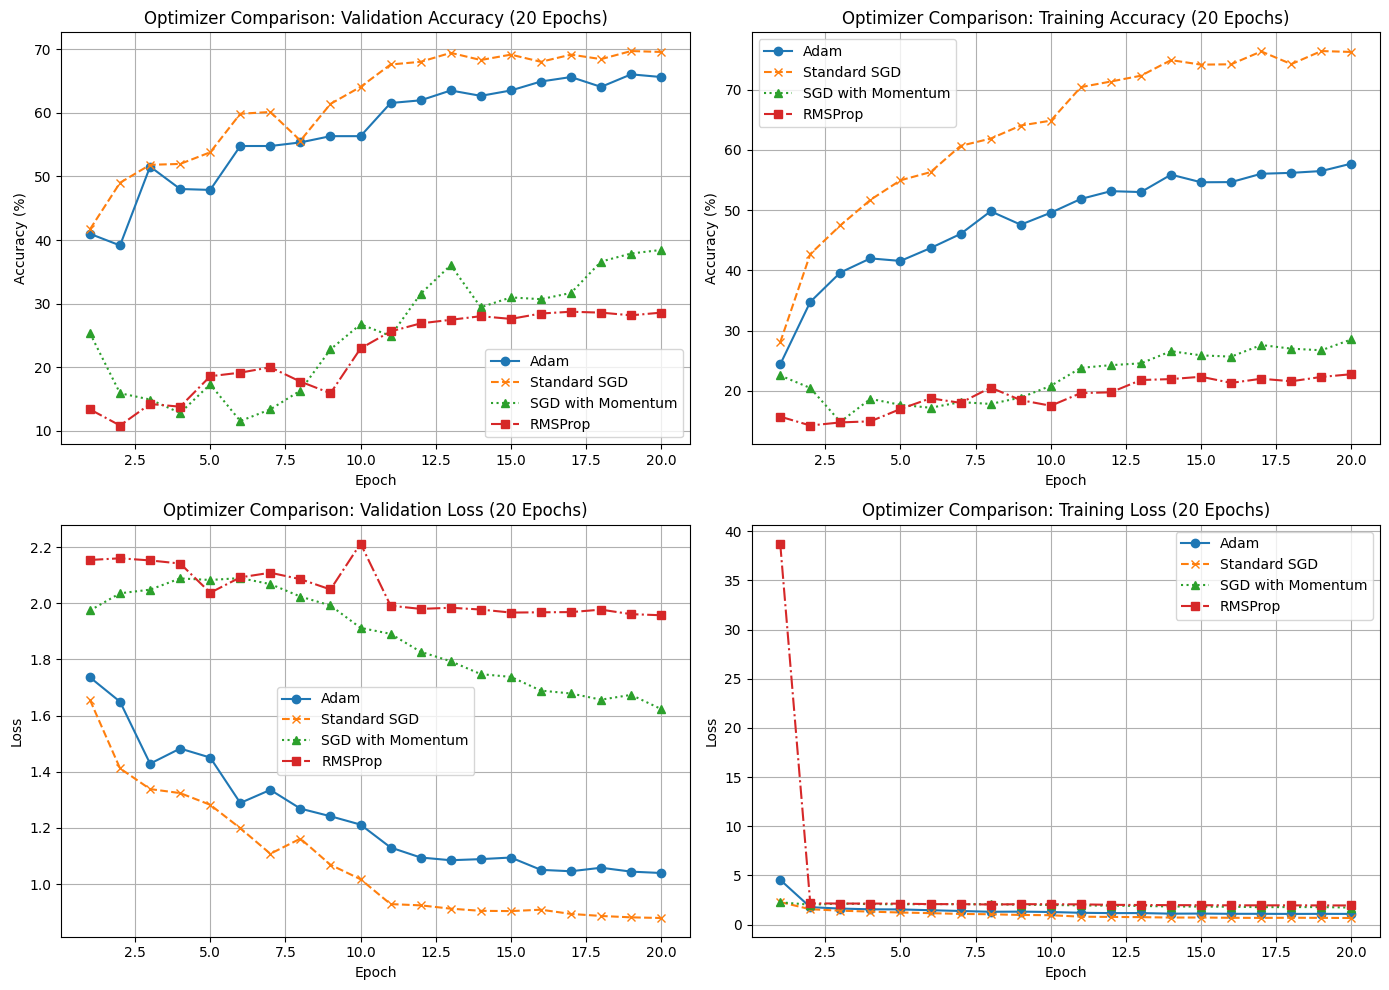


Optimizer Comparison plots generated.


In [13]:
plt.figure(figsize=(14, 10))

# === Plot 1: Validation Accuracy ===
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_val_accuracies, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_val_accuracies, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_val_accuracies, marker='^', linestyle=':', label='SGD with Momentum')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), rmsprop_val_accuracies, marker='s', linestyle='-.', label='RMSProp')
plt.title(f"Optimizer Comparison: Validation Accuracy ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# === Plot 2: Training Accuracy ===
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_train_accuracies, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_train_accuracies, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_train_accuracies, marker='^', linestyle=':', label='SGD with Momentum')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), rmsprop_train_accuracies, marker='s', linestyle='-.', label='RMSProp')
plt.title(f"Optimizer Comparison: Training Accuracy ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# === Plot 3: Validation Loss ===
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_val_losses, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_val_losses, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_val_losses, marker='^', linestyle=':', label='SGD with Momentum')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), rmsprop_val_losses, marker='s', linestyle='-.', label='RMSProp')
plt.title(f"Optimizer Comparison: Validation Loss ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# === Plot 4: Training Loss ===
plt.subplot(2, 2, 4)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_train_losses, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_train_losses, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_train_losses, marker='^', linestyle=':', label='SGD with Momentum')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), rmsprop_train_losses, marker='s', linestyle='-.', label='RMSProp')
plt.title(f"Optimizer Comparison: Training Loss ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nOptimizer Comparison plots generated.")


In [14]:
def evaluate_on_test_set_comp(model_instance, model_path, test_loader_comp, device_comp):
    model_instance.load_state_dict(torch.load(model_path))
    model_instance.to(device_comp)
    model_instance.eval()

    test_correct = 0
    test_total = 0

    with torch.no_grad():
        test_loop = tqdm(test_loader_comp, desc=f"Evaluating Test Set for model from {model_path}", leave=False)
        for images, labels in test_loop:
            images, labels = images.to(device_comp), labels.to(device_comp)
            outputs = model_instance(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    return test_accuracy


print("\n--- Evaluating Comparison Models on Test Set ---")

adam_final_test_accuracy = evaluate_on_test_set_comp(model_adam_comp, adam_comp_model_path, test_loader, device)
sgd_final_test_accuracy = evaluate_on_test_set_comp(model_sgd_comp, sgd_comp_model_path, test_loader, device)
sgd_momentum_final_test_accuracy = evaluate_on_test_set_comp(model_sgd_momentum_comp, sgd_momentum_comp_model_path, test_loader, device)
rmsprop_final_test_accuracy = evaluate_on_test_set_comp(model_rmsprop_comp, rmsprop_comp_model_path, test_loader, device)


print("\n" + "="*75)
print("       Optimizer Performance Comparison Summary       ")
print("="*75 + "\n")
print(f"Final Test Accuracy for Adam: {adam_final_test_accuracy:.2f}%")
print(f"Final Test Accuracy for Standard SGD: {sgd_final_test_accuracy:.2f}%")
print(f"Final Test Accuracy for SGD with Momentum: {sgd_momentum_final_test_accuracy:.2f}%")
print(f"Final Test Accuracy for RMSProp: {rmsprop_final_test_accuracy:.2f}%")

print("\nOptimizer Comparison Test Evaluation Complete.")



--- Evaluating Comparison Models on Test Set ---



       Optimizer Performance Comparison Summary       

Final Test Accuracy for Adam: 66.90%
Final Test Accuracy for Standard SGD: 71.77%
Final Test Accuracy for SGD with Momentum: 44.23%
Final Test Accuracy for RMSProp: 28.93%

Optimizer Comparison Test Evaluation Complete.
